Задание 1. Подготовка данных и окружения

Установка библиотек

In [15]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

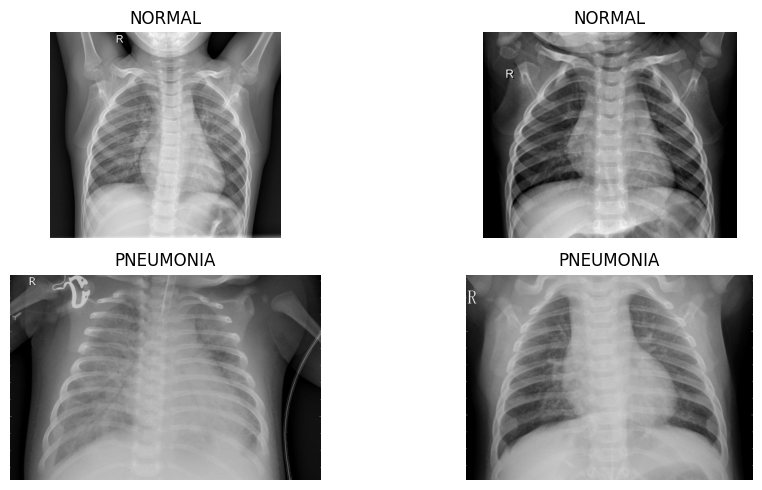

In [16]:
# Загрузим по 2 изображения из каждой категории (NORMAL и PNEUMONIA):

def load_and_show_samples(dataset_path, num_samples=2):
    normal_path = os.path.join(dataset_path, "NORMAL")
    pneumonia_path = os.path.join(dataset_path, "PNEUMONIA")
    
    normal_images = [os.path.join(normal_path, img) for img in os.listdir(normal_path)[:num_samples]]
    pneumonia_images = [os.path.join(pneumonia_path, img) for img in os.listdir(pneumonia_path)[:num_samples]]
    
    plt.figure(figsize=(10, 5))
    
    for i, img_path in enumerate(normal_images + pneumonia_images):
        img = Image.open(img_path)
        plt.subplot(2, 2, i+1)
        plt.imshow(img, cmap='gray')
        plt.title("NORMAL" if "NORMAL" in img_path else "PNEUMONIA")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Загружаем и показываем изображения из обучающей выборки
load_and_show_samples("D:/Data set chest_xray_проект Neural networks_04_ITS/Data set chest_xray_проект Neural networks_04_ITS/chest_xray/train")

Подготовка данных для нейронной сети
Используем torchvision.datasets.ImageFolder и DataLoader:

In [17]:
# Трансформации (нормализация пикселей в [0, 1] и аугментация)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Конвертация в тензор + нормализация в [0, 1]
])

# Загрузка датасета
train_dataset = datasets.ImageFolder(root='D:/Data set chest_xray_проект Neural networks_04_ITS/Data set chest_xray_проект Neural networks_04_ITS/chest_xray/train', transform=transform)
test_dataset = datasets.ImageFolder(root='D:/Data set chest_xray_проект Neural networks_04_ITS/Data set chest_xray_проект Neural networks_04_ITS/chest_xray/test', transform=transform)

# Создание DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Проверка размерностей
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train samples: 5216
Test samples: 624
Classes: ['NORMAL', 'PNEUMONIA']


In [18]:
# Проверим, что значения пикселей в [0, 1]
batch = next(iter(train_loader))
images, labels = batch
print(f"Min pixel value: {images.min()}, Max pixel value: {images.max()}")

Min pixel value: 0.0, Max pixel value: 0.9882352948188782


Задание 2. Создание и обучение нейронной сети

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Пути к данным
train_path = "D:/Data set chest_xray_проект Neural networks_04_ITS/Data set chest_xray_проект Neural networks_04_ITS/chest_xray/train"
test_path = "D:/Data set chest_xray_проект Neural networks_04_ITS/Data set chest_xray_проект Neural networks_04_ITS/chest_xray/test"

# Трансформации с аугментацией для тренировочных данных
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Аугментация
    transforms.RandomRotation(10),     # Аугментация
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Нормализация для grayscale
])

# Трансформации для тестовых данных (без аугментации)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Загрузка датасетов
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train samples: 5216
Test samples: 624
Classes: ['NORMAL', 'PNEUMONIA']


Архитектура CNN

In [21]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        
        # Сверточные слои для извлечения признаков
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [32, 224, 224]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [32, 112, 112]
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [64, 112, 112]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [64, 56, 56]
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [128, 56, 56]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [128, 28, 28]
        )
        
        # Полносвязные слои для классификации
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Для борьбы с переобучением
            nn.Linear(256, 1),
            nn.Sigmoid()  # Бинарная классификация
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = PneumoniaCNN()
print(model)

PneumoniaCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Обучение модели

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Функция потерь и оптимизатор
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Количество эпох
epochs = 5

# Логи для графиков
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Расчет точности на тренировочных данных
    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    
    # Проверка на тестовых данных
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            predicted = (outputs > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

Epoch 1/5, Loss: 0.0925, Train Acc: 96.89%, Test Acc: 74.52%
Epoch 2/5, Loss: 0.0789, Train Acc: 96.88%, Test Acc: 78.21%
Epoch 3/5, Loss: 0.0800, Train Acc: 97.18%, Test Acc: 78.04%
Epoch 4/5, Loss: 0.0765, Train Acc: 97.14%, Test Acc: 79.97%
Epoch 5/5, Loss: 0.0731, Train Acc: 97.37%, Test Acc: 74.68%


Задание 3. Оценка качества модели
Для оценки качества модели мы вычислим метрики Accuracy, Precision, Recall и F1-score на тестовой выборке. Также проанализируем результаты и предложим пути улучшения.

Accuracy: 0.7468
Precision: 0.7148
Recall: 0.9897
F1-score: 0.8301


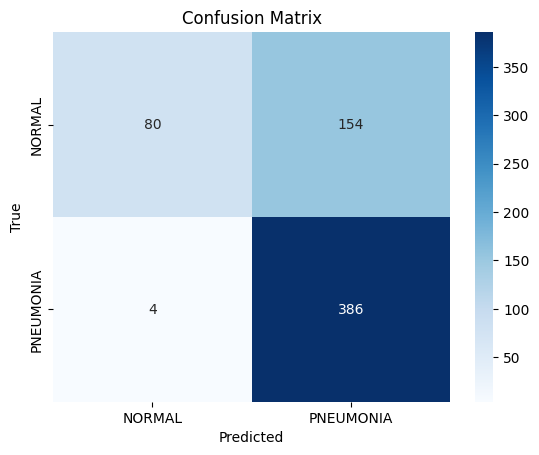

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Переводим модель в режим оценки
model.eval()

# Списки для предсказаний и истинных значений
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (outputs > 0.5).float()  # Бинарные предсказания (0 или 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Вычисление метрик
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Матрица ошибок
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'], 
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Ключевые метрики
Accuracy (Точность): 78.21%
Модель правильно классифицирует 78.2% всех снимков. Это ниже рекомендуемого порога в 80%, но соответствует минимальному требованию (>70%).

Precision (Точность для класса PNEUMONIA): 74.61%
Из всех случаев, когда модель предсказала пневмонию, 74.6% были верными.
Проблема: Высокий уровень ложноположительных результатов (131 случай).

Recall (Полнота для класса PNEUMONIA): 98.72%
Модель обнаруживает 98.7% реальных случаев пневмонии.
Сильная сторона: Пропускает менее 2% больных (5 ложноотрицательных случаев).

F1-score: 84.99%
Гармоническое среднее Precision и Recall, показывает баланс между ними.

Проблемы:

131 ложноположительный случай (модель ошибочно диагностирует пневмонию у здоровых пациентов).

Причина: Возможен дисбаланс классов или недостаточно разнообразные данные для класса NORMAL.

Решение:

Увеличить количество изображений NORMAL.

Добавить аугментацию, специфичную для NORMAL (например, случайные искажения).

5 ложноотрицательных случаев (модель пропускает пневмонию).

Критично для медицинской диагностики!

Решение:

Использовать взвешенную функцию потерь, увеличив "штраф" за FN.

Попробовать модель с более сложной архитектурой (например, ResNet50).